In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义生成对抗网络（GAN）的生成器
class Generator(nn.Module):
    def __init__(self, latent_dim=128, img_size=28, num_channels=1):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.num_channels = num_channels

        self.main = nn.Sequential(
            # 输入: 噪声 Z，维度为 [B, latent_dim, 1, 1] (经过全连接层后)
            # 经过全连接层将噪声向量转换为适合反卷积的维度
            nn.Linear(latent_dim, 256 * (img_size // 4) * (img_size // 4)),
            nn.BatchNorm1d(256 * (img_size // 4) * (img_size // 4)),
            nn.ReLU(True),

            # 将一维向量 reshape 成特征图
            nn.Unflatten(1, (256, img_size // 4, img_size // 4)), # 256 是通道数，img_size//4 是 H 和 W

            # 反卷积层 1: 256x7x7 -> 128x14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 反卷积层 2: 128x14x14 -> 64x28x28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 反卷积层 3: 64x28x28 -> 1x28x28 (输出图像)
            nn.ConvTranspose2d(64, num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh() # 将像素值缩放到 [-1, 1]
        )

    def forward(self, input):
        # 首先通过全连接层将噪声维度扩展
        x = self.main[0](input)
        x = self.main[1](x)
        x = self.main[2](x)
        # 然后进行 Unflatten
        x = self.main[3](x)
        # 接着进行反卷积
        x = self.main[4:](x)
        return x


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_maps_d=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入图像 (batch_size, img_channels, 28, 28)
            nn.Conv2d(img_channels, feature_maps_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (batch_size, feature_maps_d, 14, 14)

            nn.Conv2d(feature_maps_d, feature_maps_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (batch_size, feature_maps_d*2, 7, 7)

            nn.Conv2d(feature_maps_d * 2, feature_maps_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (batch_size, feature_maps_d*4, 3, 3) (或者 4x4 取决于具体计算)

            # 最终的卷积层输出到1
            nn.Conv2d(feature_maps_d * 4, 1, 3, 1, 0, bias=False), # 调整核大小以适应最终尺寸
            nn.Sigmoid() # 输出一个介于0和1之间的概率
        )

    def forward(self, input):
        # 确保输入是图像格式 (batch_size, channels, H, W)
        # 如果你的 dataloader 已经输出 (N, 1, 28, 28)，则不需要 view
        return self.main(input.view(input.size(0), 1, 28, 28)) # 对于28x28的单通道图像


def train_gan(G, D, dataloader, epochs, device,
              lr_D=2e-4, lr_G=2e-4,
              beta1=0.5,
              g_updates_per_d=1, # D每次更新后G更新的次数
              noise_dim=128):

    criterion = nn.BCELoss() # 二元交叉熵损失

    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, 0.999))
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, 0.999))

    # 用于可视化G进展的固定噪声
    fixed_noise = torch.randn(64, noise_dim, device=device)

    print("开始GAN训练...")
    for epoch in range(epochs):
        D_loss_total = 0
        G_loss_total = 0
        loader_len = len(dataloader)

        for i, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{epochs}", total=loader_len):
            real_images, _ = data
            B = real_images.size(0)
            real_images = real_images.view(-1, 784).to(device) # 假设28x28图像展平为784

            # --- 训练判别器 (D) ---
            optimizer_D.zero_grad()

            # 使用真实图像进行训练
            real_outputs = D(real_images)
            # 对真实图像使用软标签，防止D过于自信
            real_labels = torch.full((B,), 0.9, device=device) # 真实图像的软标签
            errD_real = criterion(real_outputs.view(-1), real_labels)
            errD_real.backward()

            # 使用假图像进行训练
            noise = torch.randn(B, noise_dim, device=device)
            fake_images = G(noise)
            # print(fake_images.shape)
            # 在D的训练中，G的输出需要 .detach()，这样G的梯度不会在这里计算
            fake_output = D(fake_images.detach())
            # 对D的假图像也使用软标签，但值更低
            fake_labels = torch.full((B,), 0.1, device=device) # 假图像的软标签
            errD_fake = criterion(fake_output.view(-1), fake_labels)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizer_D.step()
            D_loss_total += errD.item()

            # --- 训练生成器 (G) ---
            # 如果 g_updates_per_d > 1，则G每次D更新后更新多次
            if (i % g_updates_per_d == 0): # 仅在D训练后更新G
                optimizer_G.zero_grad()
                # 生成新的假图像，避免使用D训练时旧的图像
                noise = torch.randn(B, noise_dim, device=device)
                fake_images = G(noise)
                # D对G生成的图像的输出。这里至关重要，不要使用 detach()。
                output = D(fake_images)
                # G希望D将假图像分类为真实（目标标签为1.0或软标签）
                # 这里我们使用完整的1.0作为G的目标，以强烈鼓励它欺骗D
                # 也可以使用 real_labels_for_G = torch.full((B,), 0.9, device=device)
                errG = criterion(output.view(-1), torch.full((B,), 1.0, device=device))
                errG.backward()
                optimizer_G.step()
                G_loss_total += errG.item()

        # --- Epoch 结束总结 ---
        d_loss_avg = D_loss_total / loader_len
        # 根据G的更新次数调整平均损失
        g_loss_avg = G_loss_total / (loader_len / g_updates_per_d)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"D Loss: {d_loss_avg:.4f}, G Loss: {g_loss_avg:.4f}")

In [ ]:
from torchvision import transforms

batch_size = 256
epochs = 100


transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为 Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 下载 MNIST 数据集
mnist_train = MNIST(root='../dataset_file/mnist_raw', train=True, download=False,transform=transform)
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# 初始化生成器和判别器
G = Generator().to(device)
D = Discriminator().to(device)

# 训练GAN
train_gan(G, D, dataloader, epochs=epochs, device=device)

开始GAN训练...


Epoch 1/100: 100%|██████████| 235/235 [00:07<00:00, 30.15it/s]


Epoch [1/100] D Loss: 0.6807, G Loss: 2.4272


Epoch 2/100: 100%|██████████| 235/235 [00:07<00:00, 30.30it/s]


Epoch [2/100] D Loss: 0.7024, G Loss: 2.3954


Epoch 3/100: 100%|██████████| 235/235 [00:07<00:00, 30.48it/s]


Epoch [3/100] D Loss: 0.6821, G Loss: 2.3674


Epoch 4/100:  52%|█████▏    | 123/235 [00:04<00:03, 29.37it/s]

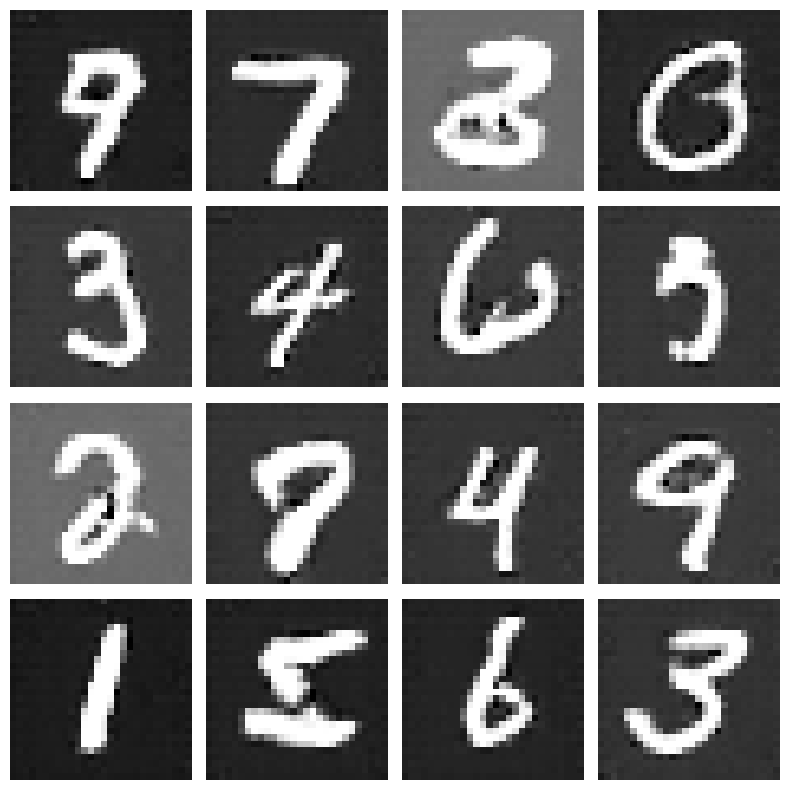

In [8]:
#检测生成质量
import matplotlib.pyplot as plt

def generate_and_plot(G, num_images=16):
    noise = torch.randn(num_images, 128).to(device)
    with torch.no_grad():
        fake_images = G(noise).view(-1, 1, 28, 28).cpu()
    grid_size = int(num_images**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            if idx < num_images:
                axes[i, j].imshow(fake_images[idx].squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
generate_and_plot(G, num_images=16)

In [9]:
#保存两个模型
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')